# ML-based-WAF Classifier

This notebook trains a WAF model with the [SQL Injection Dataset from Kaggle](https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset), based off vladan stojnic's open source [ML-based-WAF](https://github.com/vladan-stojnic/ML-based-WAF) implementation.

Tested classifier types: 
* Non-Linear SVM classifier;
* Stochastic Gradient Descent

WARNING: Only works with conda env set to mlWaf (provided in /deps/conda_envs).

#### Library imports


In [9]:
import shutup
shutup.please()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [10]:
data_df = pd.read_json('~/localdev/tcc/datasets/kaggle/SQLiV5.json' , orient='records')
data_df

,pattern,type
0,""" or pg_sleep ( __TIME__ ) --",sqli
1,create user name identified by pass123 tempora...,sqli
2,AND 1 = utl_inaddr.get_host_address ( ...,sqli
3,select * from users where id = '1' or @ @1 ...,sqli
4,"select * from users where id = 1 or 1#"" ( ...",sqli
...,...,...
40525,DELETE FROM door WHERE grow = 'small',valid
40526,DELETE FROM tomorrow,valid
40527,SELECT wide ( s ) FROM west,valid
40528,SELECT * FROM ( SELECT slide FROM breath ),valid


sqli     21013
valid    19517
Name: type, dtype: int64


<AxesSubplot:ylabel='type'>

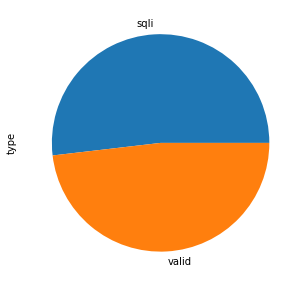

In [11]:
counts = data_df['type'].value_counts()
print(counts)
counts.plot.pie(figsize=(5, 5))

#### Split into training and testing labels


In [12]:
X = data_df['pattern'].to_numpy().astype(str)
y = data_df['type'].to_numpy().astype(str)    
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

#### Prepare for GridSearchCV classification for best params based on Classifier type
Note - Linear with ngram range [1,4] seems to peform slightly worse than rbf kernel with ngram_range [1,2].

In [ ]:
pipe = make_pipeline(
    TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024), 
    SVC())
param_grid = {'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 4)], 
              'svc__C': [1, 10], 'svc__kernel': ['linear', 'rbf']}  
grid = GridSearchCV(pipe, param_grid, cv = 2, verbose = 4, n_jobs=4)
grid.fit(trainX, trainY)
grid.best_params_

#### 1. Train model with best params
Found by experimenting with top results from GridSearchCV run

In [13]:
pipe = make_pipeline(
    TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 2)), 
    SVC(C = 10, kernel = 'rbf', probability=True, gamma='scale'))
pipe.fit(trainX, trainY)
pipe.score(testX, testY)

0.9978288759498668

In [7]:
pipe.score(trainX, trainY)

0.9998684080665855

#### 2. Train model with suggested GridSearch optimal params
**WARNING** do not run this cell if the previous cell has been executed!

Uses best result from GridSearchCV run - however the performance is slightly worse.

In [18]:
pipe = make_pipeline(
    TfidfVectorizer(input = 'content', lowercase = True, analyzer = 'char', max_features = 1024, ngram_range = (1, 4)), 
    SVC(C = 10, kernel = 'linear', probability=True, gamma='scale'))
pipe.fit(trainX, trainY)
pipe.score(testX, testY)

0.9968895800933126

In [30]:
predY = pipe.predict(testX)
print(classification_report(testY, predY))
print(confusion_matrix(testY, predY))

              precision    recall  f1-score   support

        sqli       1.00      1.00      1.00      5254
       valid       1.00      1.00      1.00      4879

    accuracy                           1.00     10133
   macro avg       1.00      1.00      1.00     10133
weighted avg       1.00      1.00      1.00     10133

[[5235   19]
 [   3 4876]]


In [31]:
joblib.dump(pipe, 'test_svc_classifier.dump')

['test_svc_classifier_extra_moled.dump']

#### WAF-A-MoLE query testing
For testing with and without WAF queries in dataset.

In [32]:
clf = joblib.load('test_svc_classifier_extra_moled.dump')
# query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo; for SQL Injection
type assumed: ['sqli']
probability of being SQL injection is: 0.7964570358168855


In [12]:
clf = joblib.load('test_svc_classifier_moled.dump')
# query = "admin'   OR   5o8x4x4o0o1=0o4o2b4b4o0b60#"
query = "aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo;"
print("Testing query {} for SQL Injection".format(query))
print("type assumed: {}".format(clf.predict([query])))
print("probability of being SQL injection is: {}".format(clf.predict_proba([query])[0,0]))

Testing query aDMiN'!!, OR  ;](sELeCt 9)=6O8 or\{6, OR  fAlsE}ANd true Or[FALSE?anD TRUe And trUe+and TrUe Or FalSe  OR  False#7xFKSipgJo; for SQL Injection
type assumed: ['valid']
probability of being SQL injection is: 0.4547222533415284
